## Import

In [1]:
import pandas as pd
import numpy as np
import random
import os
from time import time
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from fasttext import load_model
import math

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
import lightgbm as lgb


## Settings

In [2]:
DATA_PATH = "/home/knikaido/work/atma10/data/"
TRAIN_PATH = DATA_PATH + "train.csv"
TEST_PATH = DATA_PATH + "test.csv"
SUB_PATH = DATA_PATH + "atmacup10__sample_submission.csv"

In [3]:
SEED = 42
N_SPLITS = 5
SHUFFLE = True
LGBM_PARAMS = {'num_leaves': 32,
               'min_data_in_leaf': 64,
               'objective': 'regression',
               'max_depth': -1,
               'learning_rate': 0.05,
               "boosting": "gbdt",
               "bagging_freq": 1,
               "bagging_fraction": 0.8,
               "bagging_seed": SEED,
               "verbosity": -1,
              'reg_alpha': 0.1,
              'reg_lambda': 0.3,
              'colsample_bytree': 0.7,
              'metric':"rmse",
              'num_threads':6,
         }

LGBM_FIT_PARAMS = {
    'num_boost_round': 10000,
    'early_stopping_rounds': 1000,
    'verbose_eval': 200,
}

SAVE_TEST_SUB_PATH = "sub13.csv"
SAVE_OOF_SUB_PATH = "oof13.csv"

## Utility

In [4]:
def seed_everything(seed: int):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
seed_everything(SEED)

In [5]:
class Timer:
    def __init__(self, logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None, sep=' '):

        if prefix: format_str = str(prefix) + sep + format_str
        if suffix: format_str = format_str + sep + str(suffix)
        self.format_str = format_str
        self.logger = logger
        self.start = None
        self.end = None

    @property
    def duration(self):
        if self.end is None:
            return 0
        return self.end - self.start

    def __enter__(self):
        self.start = time()

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.end = time()
        out_str = self.format_str.format(self.duration)
        if self.logger:
            self.logger.info(out_str)
        else:
            print(out_str)

## Feature Engineering

In [6]:
train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)
len_train = len(train)

saturation_train = pd.read_csv(DATA_PATH + 'saturation_train.csv')
train = train.merge(saturation_train, how='left', on='object_id')
saturation_test = pd.read_csv(DATA_PATH + 'saturation_test.csv')
test = test.merge(saturation_test, how='left', on='object_id')

# value50_train = pd.read_csv(DATA_PATH + 'value50_train.csv')
# train = train.merge(value50_train, how='left', on='object_id')
# value50_test = pd.read_csv(DATA_PATH + 'value50_test.csv')
# test = test.merge(value50_test, how='left', on='object_id')

y = np.log1p(train["likes"])
whole_df = pd.concat([train, test]).reset_index(drop=True)
train

,object_id,art_series_id,title,description,long_title,principal_maker,principal_or_first_maker,sub_title,copyright_holder,more_title,acquisition_method,acquisition_date,acquisition_credit_line,dating_presenting_date,dating_sorting_date,dating_period,dating_year_early,dating_year_late,likes,saturation
0,0011d6be41612ec9eae3,93c092ba70beab248f31,The Avenue of Birches,NaN,"The Avenue of Birches, Jan Hackaert, 1660 - 1685",Jan Hackaert,Jan Hackaert,h 66.5cm × w 53.7cm × t 2.5cm × d 4.7cm,NaN,The Avenue of Birches,purchase,1808-01-01T00:00:00,NaN,1660 - 1685,1660.0,17,1660.0,1685.0,48,239.0
1,0012765f7a97ccc3e9e9,95c14fb11c54281ad7e0,Struik in bloei,NaN,"Struik in bloei, Richard Tepe (attributed to),...",Richard Tepe,Richard Tepe,h 165mm × w 223mm,erven Richard Tepe,Struik in bloei,purchase,2000-01-01T00:00:00,NaN,c. 1900 - c. 1930,1900.0,19,1900.0,1930.0,2,110.0
2,0017be8caa87206532cb,4c406890d208fe01f8fb,Portret van een vrouw,"Portret van eenvrouw, zittend naast een tafel.","Portret van een vrouw, Tresling & Comp., 1860 ...",Tresling & Comp.,Tresling & Comp.,h 87mm × w 56mm,NaN,Portret van een vrouw,gift,2007-01-01T00:00:00,"Gift of M.M. Boom, Leiden",1860 - 1880,1860.0,19,1860.0,1880.0,5,NaN
3,00181d86ff1a7b95864e,fa0891535500a4973db2,A St Bernard Dog,"Een sint-bernardshond, staand in een landschap...","A St Bernard Dog, Bernard te Gempt, c. 1850 - ...",Bernard te Gempt,Bernard te Gempt,h 179cm × w 248cm × t 4cm,NaN,A St Bernard Dog,bequest,1881-01-01T00:00:00,"J. Hilman Bequest, Amsterdam",c. 1850 - c. 1879,1850.0,19,1850.0,1879.0,100,229.0
4,001c52ae28ec106d9cd5,8065ed5063c5887e677d,Woelige zee met zeilschepen,Woelige zee met zeilschepen.,"Woelige zee met zeilschepen, anonymous, 1825 -...",anonymous,anonymous,h 13cm × w 17.5cm × d 0.7cm,NaN,Woelige zee met zeilschepen,unknown,1971-01-01T00:00:00,NaN,1825 - 1874,1825.0,19,1825.0,1874.0,7,255.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12021,ffedf8af4fd5b3873164,2e4695e7f3260d52b3e6,De schilder H.W. Mesdag voor een doek,NaN,"De schilder H.W. Mesdag voor een doek, Delboy ...",Delboy & Baer,Delboy & Baer,h 90mm × w 140mm,NaN,De schilder H.W. Mesdag voor een doek H W Mesdag,transfer,1994-01-01T00:00:00,NaN,1900 - 1920,1900.0,19,1900.0,1920.0,4,61.0
12022,ffee34705ea44e1a0f79,7aa656a9ef243d93d009,"Kaart van de streek tussen Mannheim en Landau,...","Kaart van de streek tussen Mannheim, Speyer en...","Kaart van de streek tussen Mannheim en Landau,...",Abraham Allard,Abraham Allard,h 245mm × w 278mm,NaN,"Kaart van de streek tussen Mannheim en Landau,...",purchase,1881-01-01T00:00:00,NaN,1701 - 1714,1701.0,18,1701.0,1714.0,0,183.0
12023,ffefbe1faf771aa4f790,e79c2e74ed17533a7e56,Storm op het IJ aan het Blauwhoofd van Amsterd...,Zeilschepen in de problemen op het IJ ter hoog...,Storm op het IJ aan het Blauwhoofd van Amsterd...,Noach van der Meer (II),Noach van der Meer (II),h 217mm × w 306mm,NaN,Storm op het IJ aan het Blauwhoofd van Amsterd...,transfer,1887-01-01T00:00:00,NaN,1778,1778.0,18,1778.0,1778.0,0,95.0
12024,fff08e76cbb969eaddc7,510358b74c1104edbbbd,"Het rad van fortuin, ca. 1689","Het rad van fortuin, ca. 1689. Spotprent op de...","Het rad van fortuin, ca. 1689, Romeyn de Hoogh...",Romeyn de Hooghe,Romeyn de Hooghe,h 560mm × w 405mm,NaN,"Het rad van fortuin, ca. 1689 'T Hedendaags Ra...",purchase,1881-01-01T00:00:00,NaN,1689 - 1690,1689.0,17,1689.0,1690.0,14,139.0


In [7]:
def create_numeric_feature(input_df):
    use_columns = [
        'dating_period',
        'dating_year_early',
        'dating_year_late',
        'saturation',
#         'value50'
    ]
    output_df = input_df[use_columns].copy()
#     output_df['date_range'] = input_df['dating_year_late'] - input_df['dating_year_early']

    return output_df

In [8]:
def create_size_feature(input_df):
    
    output_df = pd.DataFrame()
    for i, axis in  enumerate(['h', 'w', 't', 'd', 'w']):
        if i <= 3:
            column_name = f'size_{axis}'
            size_info = input_df['sub_title'].str.extract(r'{} (\d*\/\d*|\d*|\d*\.\d*)(cm|mm)'.format(axis)) # 正規表現を使ってサイズを抽出
        else :
            column_name = 'weight'
            size_info = input_df['sub_title'].str.extract(r'{} (\d*\/\d*|\d*|\d*\.\d*)(kg)'.format(axis)) # 正規表現を使ってサイズを抽出
        size_info = size_info.rename(columns={0: column_name, 1: 'unit'})
        size_info[column_name] = size_info[column_name].str.replace('/', '.')
        size_info[column_name] = size_info[column_name].replace('', np.nan).astype(float) # dtypeがobjectになってるのでfloatに直す
        size_info[column_name] = size_info.apply(lambda row: row[column_name] * 10 if row['unit'] == 'cm' else row[column_name], axis=1) # 　単位をmmに統一する
        output_df[column_name] = size_info[column_name] # trainにくっつける
    output_df['area'] = output_df['size_t'] * output_df['size_w']

    return output_df

In [9]:
def create_string_length_feature(input_df):
    out_df = pd.DataFrame()

    str_columns = [
        'title', 
        'long_title',
        'sub_title',
        'more_title',
#         'description'
        # and more
    ]

    for c in str_columns:
        out_df[c] = input_df[c].str.len()

    return out_df.add_prefix('StringLength_')

In [10]:
def create_isnan_feature(input_df):
    out_df = pd.DataFrame()

    str_columns = [
        'description',
#         'acquisition_credit_line', 
        # and more
    ]

    for c in str_columns:
        out_df[c] = input_df[c].isnull().astype('int')

    return out_df.add_prefix('isnan_')

In [11]:
def create_count_encoding_feature(input_df):
    ## 'principal_or_first_maker'は'principal_maker'と相関高いので削除
    use_columns = ['principal_maker',
        'copyright_holder','acquisition_method',
       'acquisition_credit_line', 
       'dating_period', 'dating_year_early',
       'dating_year_late']

    out_df = pd.DataFrame()
    for column in use_columns:
        vc = input_df[column].value_counts()
        out_df[column] = input_df[column].map(vc)

    return out_df.add_prefix('CE_')

In [12]:
def create_language_feature(input_df):
    use_columns = ['title', 'description', 'more_title',
        'long_title', 'principal_maker', 'principal_or_first_maker',
        'copyright_holder','acquisition_method',
       'acquisition_credit_line']
    model = load_model(DATA_PATH + "lid.176.bin")
    
    out_df = pd.DataFrame()
    for column in use_columns:
        out_df[column] = input_df[column].fillna("").map(
            lambda x: model.predict(x.replace("\n", ""))[0][0]).astype(str)
        le = LabelEncoder()
        out_df[column] = le.fit_transform(out_df[column])
        
    return out_df.add_prefix('lang_')

#     out_df = pd.DataFrame()
#     for column in use_columns:
#         lang_series = input_df[column].fillna("").map(
#             lambda x: model.predict(x.replace("\n", ""))[0][0]).astype(str)
        
#         # あまり巨大な行列にならないよう, 出現回数が 20 回を下回るカテゴリは考慮しない
#         vc = lang_series.value_counts()
#         vc = vc[vc > 20]

#         # 明示的に catgories を指定して, input_df によらず列の大きさが等しくなるようにする
#         cat = pd.Categorical(lang_series, categories=vc.index)

#         # このタイミングで one-hot 化
#         out_i = pd.get_dummies(cat)
#         # column が Catgory 型として認識されているので list にして解除する (こうしないと concat でエラーになる)
#         out_i.columns = out_i.columns.tolist()
#         out_i = out_i.add_prefix(f'{column}=')
#         out_df = pd.concat([out_df, out_i], axis=1)
#     return out_df

In [13]:
def create_label_encoding(input_df):
    ## 'principal_or_first_maker'は'principal_maker'と相関高いが，削除するとCV下がったので残す
    use_columns = ['principal_maker', 'principal_or_first_maker',
        'copyright_holder','acquisition_method',
       'acquisition_credit_line', 
       'dating_period', 'dating_year_early',
       'dating_year_late']
    
    out_df = pd.DataFrame()
    for column in use_columns:
        out_df[column] = input_df[column].astype(str)
        le = LabelEncoder()
        out_df[column] = le.fit_transform(out_df[column])
        
    return out_df.add_prefix('LE_')

In [14]:
def create_one_hot_encoding(input_df):
    use_columns = [
        'acquisition_method'
#         'principal_maker'
    ]
    out_df = pd.DataFrame()
    for column in use_columns:

        # あまり巨大な行列にならないよう, 出現回数が 20 回を下回るカテゴリは考慮しない
        vc = input_df[column].value_counts()
        vc = vc[vc > 10]

        # 明示的に catgories を指定して, input_df によらず列の大きさが等しくなるようにする
        cat = pd.Categorical(input_df[column], categories=vc.index)

        # このタイミングで one-hot 化
        out_i = pd.get_dummies(cat)
        # column が Catgory 型として認識されているので list にして解除する (こうしないと concat でエラーになる)
        out_i.columns = out_i.columns.tolist()
        out_i = out_i.add_prefix(f'{column}=')
        out_df = pd.concat([out_df, out_i], axis=1)
    return out_df

In [15]:
def create_maker_info(input_df):
    
    tgt = 'principal_maker'
    col = 'dating_sorting_date'
    val = 'object_id'
    plat_pivot = input_df.pivot_table(index=tgt, columns=col, values=val, aggfunc='count').reset_index()
    plat_pivot.fillna(0, inplace=True)

    n_ = 100
    pca = PCA(n_components=n_)
    plat_pca = pca.fit_transform(plat_pivot.iloc[:, 1:].values) 
    cols = [tgt[:8] +  '_' + col[-4:]+ '_' + val + '_pca_'+str(i) for i in range(n_)]
    plat_pca_df = pd.DataFrame(plat_pca, index=plat_pivot.iloc[:,0], columns=cols)
    out_df = pd.merge(input_df, plat_pca_df, on=tgt, how='left')[cols]
            
    return out_df

In [16]:
def create_maker_famouse_info(input_df):
    
    maker = pd.read_csv(DATA_PATH + 'maker.csv')
    maker['famouse_point'] = maker.iloc[:, 1:].count(axis=1)
    maker['principal_maker'] = maker['name']
    
    out_df = pd.merge(input_df, maker, on='principal_maker', how='left')
            
    return out_df['famouse_point']

In [17]:
def create_title_info(input_df):
    
    tgt = 'title'
    col = 'principal_maker'
    val = 'object_id'
    plat_pivot = input_df.pivot_table(index=tgt, columns=col, values=val, aggfunc='count').reset_index()
    plat_pivot.fillna(0, inplace=True)

    n_ = 100
    pca = PCA(n_components=n_)
    plat_pca = pca.fit_transform(plat_pivot.iloc[:, 1:].values) 
    cols = [tgt +  '_' + col[-4:]+ '_' + val + '_pca_'+str(i) for i in range(n_)]
    plat_pca_df = pd.DataFrame(plat_pca, index=plat_pivot.iloc[:,0], columns=cols)
    out_df = pd.merge(input_df, plat_pca_df, on=tgt, how='left')[cols]
            
    return out_df

In [18]:
def create_bert_description_info(input_df):
    
    bert_df = pd.read_csv(DATA_PATH + 'bert_description_info.csv')

    n_ = 100
    pca = PCA(n_components=n_)
    plat_pca = pca.fit_transform(bert_df.iloc[:, 1:].values) 
    cols = ['bert_descript_pca_'+str(i) for i in range(n_)]
    plat_pca_df = pd.DataFrame(plat_pca,  columns=cols)
            
    return plat_pca_df

In [19]:
def create_bert_more_title_info(input_df):
    
    bert_df = pd.read_csv(DATA_PATH + 'bert_more_title_info.csv')

    n_ = 100
    pca = PCA(n_components=n_)
    plat_pca = pca.fit_transform(bert_df.iloc[:, 1:].values) 
    cols = ['bert_m_title_pca_'+str(i) for i in range(n_)]
    plat_pca_df = pd.DataFrame(plat_pca,  columns=cols)
            
    return plat_pca_df

In [20]:
def create_bert_long_title_info(input_df):
    
    bert_df = pd.read_csv(DATA_PATH + 'bert_long_title_info.csv')

    n_ = 100
    pca = PCA(n_components=n_)
    plat_pca = pca.fit_transform(bert_df.iloc[:, 1:].values) 
    cols = ['bert_l_title_pca_'+str(i) for i in range(n_)]
    plat_pca_df = pd.DataFrame(plat_pca,  columns=cols)
            
    return plat_pca_df

In [21]:
def create_material_info(input_df):
    
    material_df = pd.read_csv(DATA_PATH + 'material_info.csv')
    out_df = pd.merge(input_df, material_df, on='object_id', how='left')
            
    return out_df[material_df.columns].drop('object_id', axis=1)

In [22]:
def create_technique_info(input_df):
    
    technique_df = pd.read_csv(DATA_PATH + 'technique_info.csv')
    out_df = pd.merge(input_df, technique_df, on='object_id', how='left')
            
    return out_df[technique_df.columns].drop('object_id', axis=1)

In [23]:
def create_place_info(input_df):
    
    production_country = pd.read_csv(DATA_PATH + 'production_place_country.csv')   
    out_df = pd.merge(input_df, production_country, on='object_id', how='left')
            
    return out_df[production_country.columns].drop('object_id', axis=1)

In [24]:
def create_person_info(input_df):
    
    person = pd.read_csv(DATA_PATH + 'person_one_hot.csv')   
    out_df = pd.merge(input_df, person, on='object_id', how='left')
            
    return out_df[person.columns].drop('object_id', axis=1)

In [25]:
def create_palette_feature(input_df):
    output_df = input_df.copy()
    palette = pd.read_csv(DATA_PATH + 'palette.csv')

    # ratio最大のものを取得
    max_palette = palette.groupby('object_id')['ratio'].max().reset_index()
    max_palette = pd.merge(max_palette, palette, on=['object_id','ratio'], how='left').rename(
        columns={"ratio":"max_ratio", "color_r":"max_palette_r", "color_g":"max_palette_g","color_b":"max_palette_b"})  
    max_palette = max_palette.loc[max_palette["object_id"].drop_duplicates().index.tolist()].reset_index()  # 同じidでmax ratioが同じものは削除
    output_df = pd.merge(output_df, max_palette, on="object_id", how="left")

    # 平均のrgbを取得
    mean_palette = palette.copy()
    mean_palette["color_r"] = palette["ratio"] * palette["color_r"]
    mean_palette["color_g"] = palette["ratio"] * palette["color_g"]
    mean_palette["color_b"] = palette["ratio"] * palette["color_b"]
    mean_palette = mean_palette.groupby("object_id").sum().reset_index().rename(
        columns={"color_r":"mean_palette_r", "color_g":"mean_palette_g","color_b":"mean_palette_b"})
    output_df = pd.merge(output_df, mean_palette, on="object_id", how="left")

    use_columns = ["max_ratio", "max_palette_r","max_palette_g","max_palette_b","mean_palette_r","mean_palette_g","mean_palette_b"]
    return output_df[use_columns]

In [26]:
def to_feature(input_df):
    """input_df を特徴量行列に変換した新しいデータフレームを返す.
    """

    processors = [
        create_isnan_feature,
        create_numeric_feature,
        create_string_length_feature,
        create_count_encoding_feature,
        create_label_encoding,
        create_size_feature,
        create_language_feature,
        create_maker_info,
        create_title_info,
        create_material_info,
        create_place_info,
        create_bert_description_info,
        create_bert_more_title_info,
        create_bert_long_title_info,
        create_maker_famouse_info,
        create_palette_feature,
        create_technique_info
#         create_person_info
#         create_one_hot_encoding
    ]

    out_df = pd.DataFrame()

    for func in tqdm(processors, total=len(processors)):
        with Timer(prefix='' + func.__name__ + ' '):
            _df = func(input_df)

        # 長さが等しいことをチェック (ずれている場合, func の実装がおかしい)
        assert len(_df) == len(input_df), func.__name__
        out_df = pd.concat([out_df, _df], axis=1)

    return out_df

In [27]:
whole_feat_df = to_feature(whole_df)

 29%|██▉       | 5/17 [00:00<00:00, 39.95it/s]

create_isnan_feature  0.004[s]
create_numeric_feature  0.001[s]
create_string_length_feature  0.024[s]
create_count_encoding_feature  0.021[s]
create_label_encoding  0.068[s]
create_size_feature  1.205[s]


create_language_feature  2.272[s]
create_maker_info  0.215[s]


 65%|██████▍   | 11/17 [00:08<00:04,  1.29it/s]

create_title_info  4.067[s]
create_material_info  0.029[s]
create_place_info  0.031[s]
create_bert_description_info  2.886[s]


 76%|███████▋  | 13/17 [00:14<00:05,  1.41s/it]

create_bert_more_title_info  3.087[s]


 88%|████████▊ | 15/17 [00:17<00:02,  1.45s/it]

create_bert_long_title_info  3.060[s]
create_maker_famouse_info  0.016[s]


100%|██████████| 17/17 [00:17<00:00,  1.04s/it]

create_palette_feature  0.391[s]
create_technique_info  0.021[s]


In [28]:
test_feat_df = whole_feat_df.iloc[len_train:].reset_index(drop=True)
train_feat_df = whole_feat_df.iloc[:len_train].reset_index(drop=True)
X = train_feat_df
X

,isnan_description,dating_period,dating_year_early,dating_year_late,saturation,StringLength_title,StringLength_long_title,StringLength_sub_title,StringLength_more_title,CE_principal_maker,...,mean_palette_g,mean_palette_b,OH_tech_printmake,OH_tech_engraving,OH_tech_photo,OH_tech_printing,OH_tech_paint,OH_tech_gilding,OH_tech_lace,OH_tech_cut
0,1,17,1660.0,1685.0,239.0,21,48,39.0,21.0,5,...,52.411413,10.170802,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,19,1900.0,1930.0,110.0,15,64,17.0,15.0,364,...,68.715265,56.557897,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
2,0,19,1860.0,1880.0,NaN,21,52,15.0,21.0,1,...,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0,19,1850.0,1879.0,229.0,16,53,25.0,16.0,1,...,115.351348,53.018787,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,19,1825.0,1874.0,255.0,27,51,27.0,27.0,3457,...,61.203895,8.837004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12021,1,19,1900.0,1920.0,61.0,37,65,16.0,48.0,3,...,158.764955,135.226073,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
12022,0,18,1701.0,1714.0,183.0,60,89,17.0,424.0,42,...,169.467314,133.864101,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12023,0,18,1778.0,1778.0,95.0,54,85,17.0,141.0,5,...,136.658390,106.899314,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
12024,0,17,1689.0,1690.0,139.0,29,72,17.0,145.0,266,...,148.076765,107.599074,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


## Train / Test

In [29]:
def calc_loss(y_true, y_pred):
    return  np.sqrt(mean_squared_error(y_true, y_pred))

In [30]:

kf = KFold(n_splits=N_SPLITS,random_state=SEED, shuffle=SHUFFLE)

y_test = np.zeros([N_SPLITS, len(test_feat_df)])
oof_pred = np.zeros_like(y, dtype=np.float)
models = []

# kfoldで分割
for i, (train_index, valid_index) in enumerate(kf.split(X, y)):

    X_train = X.iloc[train_index]
    y_train = y.iloc[train_index]
    X_valid = X.iloc[valid_index]
    y_valid = y.iloc[valid_index]

    # データセットを生成する
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid)

    # 学習
    model = lgb.train(LGBM_PARAMS,
                        lgb_train,
                        valid_sets=[lgb_eval, lgb_train],
                        **LGBM_FIT_PARAMS)

    predict_train = model.predict(X_train, num_iteration=model.best_iteration)
    predict_eval = model.predict(X_valid, num_iteration=model.best_iteration)
    oof_pred[valid_index] = predict_eval
    models.append(model)
    
    rmse_train = calc_loss(y_train, predict_train)
    rmse_eval = calc_loss(y_valid, predict_eval)
    print(f'epoch: {i} RMSE_train: {rmse_train}, RMSE_eval: {rmse_eval}')
    
    y_test[i] = model.predict(test_feat_df, num_iteration=model.best_iteration)
    
oof_score = calc_loss(y, oof_pred)
print(f'RMSE_oof: {oof_score}')

Training until validation scores don't improve for 1000 rounds
[200]	training's rmse: 0.666339	valid_0's rmse: 1.02477
[400]	training's rmse: 0.467749	valid_0's rmse: 1.01508
[600]	training's rmse: 0.348254	valid_0's rmse: 1.01564
[800]	training's rmse: 0.268974	valid_0's rmse: 1.01619
[1000]	training's rmse: 0.215711	valid_0's rmse: 1.01647
[1200]	training's rmse: 0.179394	valid_0's rmse: 1.01865
[1400]	training's rmse: 0.153172	valid_0's rmse: 1.01935
Early stopping, best iteration is:
[471]	training's rmse: 0.419153	valid_0's rmse: 1.01435
epoch: 0 RMSE_train: 0.4191527642689801, RMSE_eval: 1.0143510863273189
Training until validation scores don't improve for 1000 rounds
[200]	training's rmse: 0.664739	valid_0's rmse: 1.04001
[400]	training's rmse: 0.468479	valid_0's rmse: 1.03185
[600]	training's rmse: 0.347463	valid_0's rmse: 1.02967
[800]	training's rmse: 0.268183	valid_0's rmse: 1.03029
[1000]	training's rmse: 0.215504	valid_0's rmse: 1.03029
[1200]	training's rmse: 0.179047	val

In [31]:
y_test_sub =  np.mean(y_test,axis=0)
y_test_sub = np.expm1(y_test_sub)
sub = pd.read_csv(SUB_PATH)
sub["likes"] = y_test_sub
sub.loc[sub.likes <= 0,"likes"] = 0
sub.to_csv(SAVE_TEST_SUB_PATH,index=False)

In [32]:
oof_pred_ex = np.expm1(oof_pred)
oof_df = pd.DataFrame(oof_pred_ex)
oof_df.to_csv(SAVE_OOF_SUB_PATH,index=False)

In [33]:
1.01888342503231

1.01888342503231

## Confirm

<AxesSubplot:>

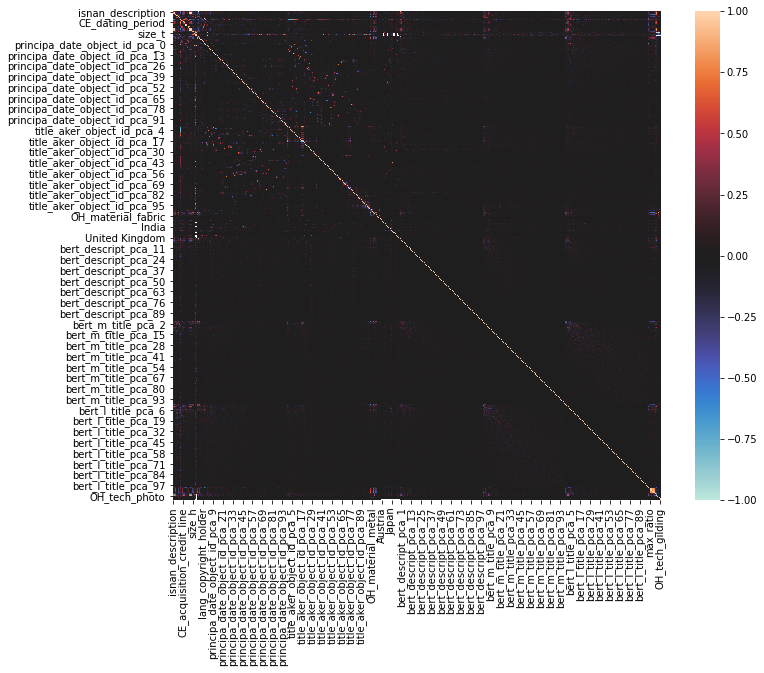

In [34]:
fig, ax = plt.subplots(figsize=(12, 9)) 
sns.heatmap(train_feat_df.corr(), square=True, vmax=1, vmin=-1, center=0)

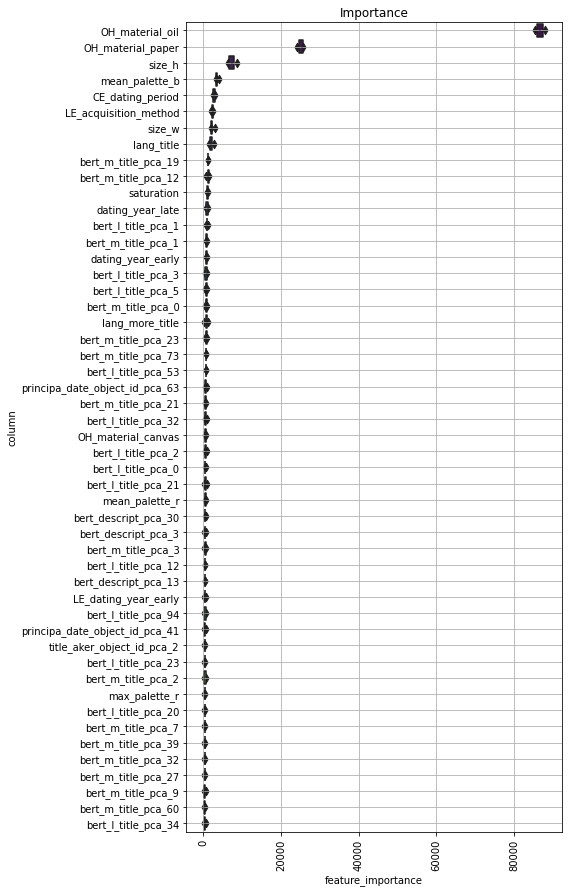

In [35]:
def visualize_importance(models, feat_train_df):
    """lightGBM の model 配列の feature importance を plot する
    CVごとのブレを boxen plot として表現します.

    args:
        models:
            List of lightGBM models
        feat_train_df:
            学習時に使った DataFrame
    """
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df['feature_importance'] = model.feature_importance(importance_type='gain')
        _df['column'] = feat_train_df.columns
        _df['fold'] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], 
                                          axis=0, ignore_index=True)

    order = feature_importance_df.groupby('column')\
        .sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(8, max(6, len(order) * .25)))
    sns.boxenplot(data=feature_importance_df, 
                  x='feature_importance', 
                  y='column', 
                  order=order, 
                  ax=ax, 
                  palette='viridis', 
                  orient='h')
    ax.tick_params(axis='x', rotation=90)
    ax.set_title('Importance')
    ax.grid()
    fig.tight_layout()
    return fig, ax

fig, ax = visualize_importance(models, train_feat_df)

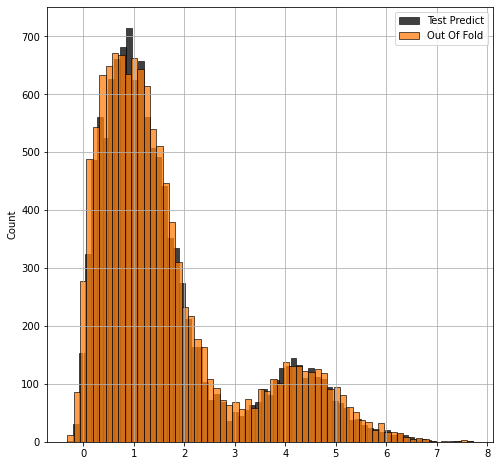

In [36]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.histplot(np.log1p(y_test_sub), label='Test Predict', ax=ax, color='black')
sns.histplot(oof_pred, label='Out Of Fold', ax=ax, color='C1')
ax.legend()
ax.grid()